In [1]:
# (C) Copyright IBM Corp. 2019, 2020, 2021, 2022.

#    Licensed under the Apache License, Version 2.0 (the "License");
#    you may not use this file except in compliance with the License.
#    You may obtain a copy of the License at

#           http://www.apache.org/licenses/LICENSE-2.0

#     Unless required by applicable law or agreed to in writing, software
#     distributed under the License is distributed on an "AS IS" BASIS,
#     WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#     See the License for the specific language governing permissions and
#     limitations under the License.


In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [4]:
from simulai.regression import DenseNetwork
from simulai.optimization import Optimizer
from simulai.residuals import SymbolicOperator

#### Viscous Burgers with null Dirichlet at the boundaries.

In [5]:
f = 'D(u, t) + (1 / 2) * D(u ** 2, x) - mu*D(D(u, x), x)'
g_u = 'u'
g_l = 'u'

input_labels = ['x', 't']
output_labels = ['u']

n_inputs = len(input_labels)
n_outputs = len(output_labels)

#### Dimensions and field properties.

In [6]:
X_DIM = 100
T_DIM = 200
L = 1.0
x_0 = -1.0
T = 1
u0 = -1

#### Number of epochs and learning rate for the ADAM optimizer.

In [7]:
n_epochs = 20_000 
lr = 1e-3

#### Constructing the regular grid.

In [8]:
x_interval = [x_0, L]
t_interval = [0, T]

intervals = [x_interval, t_interval]

x_0, x_L = x_interval
t_0, t_L = t_interval
dx = (x_L - x_0) / X_DIM
dt = (t_L - t_0) / T_DIM

grid = np.mgrid[t_0:t_L:dt, x_0:x_L:dx]

data = np.hstack([grid[1].flatten()[:, None],
                  grid[0].flatten()[:, None]])

#### Initial state.

In [9]:
data_init = np.linspace(*x_interval, X_DIM)

u_init = u0 * np.sin(np.pi * data_init)[:, None]

#### Boundaries.

In [10]:
data_boundary_x0 = np.hstack([x_interval[0] * np.ones((T_DIM, 1)),
                                      np.linspace(*t_interval, T_DIM)[:, None]])

data_boundary_xL = np.hstack([x_interval[-1] * np.ones((T_DIM, 1)),
                              np.linspace(*t_interval, T_DIM)[:, None]])

data_boundary_t0 = np.hstack([np.linspace(*x_interval, X_DIM)[:, None],
                              t_interval[0] * np.ones((X_DIM, 1))])

#### Visualizing domain and boundaries.

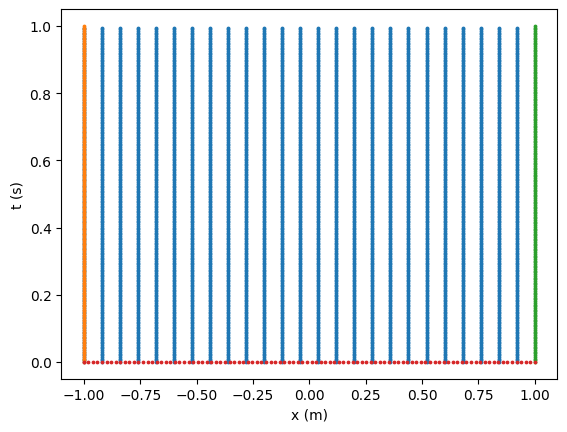

In [11]:
plt.scatter(*np.split(data[::4], 2, axis=1), s=3)
plt.scatter(*np.split(data_boundary_x0, 2, axis=1), s=3)
plt.scatter(*np.split(data_boundary_xL, 2, axis=1), s=3)
plt.scatter(*np.split(data_boundary_t0, 2, axis=1), s=3)
plt.xlabel('x (m)')
plt.ylabel('t (s)')

plt.show()
plt.close()

#### Configuration for the fully-connected network used as approximator.

In [12]:
def model():

    from simulai.models import ImprovedDenseNetwork
    from simulai.regression import SLFNN, ConvexDenseNetwork

    # Configuration for the fully-connected network
    config = {
        "layers_units": 6*[128],
        "activations": "tanh",
        "input_size": 2,
        "output_size": 1,
        "name": "net",
    }

    # Instantiating and training the surrogate model
    densenet = ConvexDenseNetwork(**config)
    encoder_u = SLFNN(input_size=n_inputs, output_size=128, activation="tanh")
    encoder_v = SLFNN(input_size=n_inputs, output_size=128, activation="tanh")

    net = ImprovedDenseNetwork(
        network=densenet,
        encoder_u=encoder_u,
        encoder_v=encoder_v,
        devices="gpu",
    )

    return net

In [13]:
net = model()
net.summary()

ImprovedDenseNetwork(
  (network): ConvexDenseNetwork(
    (net_input): Linear(in_features=2, out_features=128, bias=True)
    (net_0): Linear(in_features=128, out_features=128, bias=True)
    (net_1): Linear(in_features=128, out_features=128, bias=True)
    (net_2): Linear(in_features=128, out_features=128, bias=True)
    (net_3): Linear(in_features=128, out_features=128, bias=True)
    (net_4): Linear(in_features=128, out_features=128, bias=True)
    (net_5): Linear(in_features=128, out_features=1, bias=True)
  )
  (encoder_u): SLFNN(
    (nnet_linear_op): Linear(in_features=2, out_features=128, bias=True)
    (activation): Tanh()
  )
  (encoder_v): SLFNN(
    (nnet_linear_op): Linear(in_features=2, out_features=128, bias=True)
    (activation): Tanh()
  )
)


#### Instantiating the symbolic residual evaluator.

In [14]:
residual = SymbolicOperator(expressions=[f],
                            input_vars=input_labels,
                            auxiliary_expressions={'upper': g_u,
                                                   'lower': g_l},
                            constants={'mu': 0.01/np.pi},
                            output_vars=output_labels, function=net,
                            engine='torch',
                            device='gpu')

Using GPU.


#### Optimizer instantiation.

In [15]:
optimizer_config = {'lr' : lr}

lr_decay_scheduler_params={'name': 'ExponentialLR',
                           'gamma': 0.9,
                           'decay_frequency': 1_000}

In [16]:
optimizer = Optimizer('adam', params=optimizer_config,
                      lr_decay_scheduler_params=lr_decay_scheduler_params,
                      summary_writer=True)

Optimizer adam found in torch.optim.


#### Dictionary for communicating problem configurations to the optimizer.

In [17]:
params = {'residual': residual,
          'initial_input': data_boundary_t0,
          'initial_state': u_init,
          'boundary_input': {'upper': data_boundary_xL, 'lower': data_boundary_x0},
          'boundary_penalties': [1, 1],
          'initial_penalty': 10}

#### Executing the fitting process. 

In [18]:
 optimizer.fit(op=net, input_data=data,
               n_epochs=n_epochs, loss="pirmse",
               params=params,
               device='gpu')

There are extra trainable parameters.
Using GPU.
Using LR decay <class 'torch.optim.lr_scheduler.ExponentialLR'>.
Data transferred to GPU.
pde:9.32625789573649e-06 init:7.753337882832056e-08 bound:4.363939254403704e-08     

#### Mesh used for the final evaluation.

In [19]:
X_DIM_F = 5 * X_DIM
T_DIM_F = 5 * T_DIM

x_f = np.linspace(*x_interval, X_DIM_F)
t_f = np.linspace(*t_interval, T_DIM_F)

T_f, X_f = np.meshgrid(t_f, x_f, indexing='ij')

data_f = np.hstack([X_f.flatten()[:, None],
                    T_f.flatten()[:, None]])

#### Evaluating using the trained model. 

In [20]:
approximated_data = net.eval(input_data=data_f)

#### 2D plots.

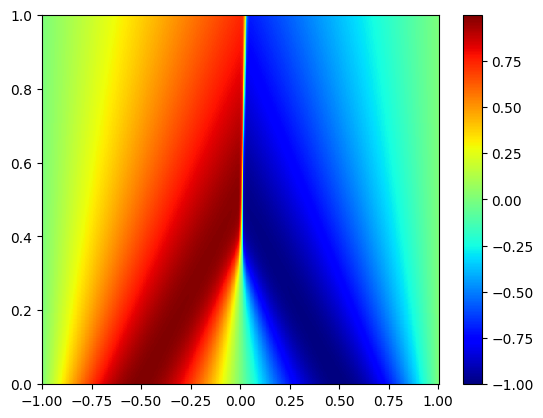

In [21]:
U_f = approximated_data.reshape(T_DIM_F, X_DIM_F)

fig, ax = plt.subplots()
ax.set_aspect('auto')
gf = ax.pcolormesh(X_f, T_f, U_f, cmap='jet')
fig.colorbar(gf)

plt.show()

#### 1D plots. 

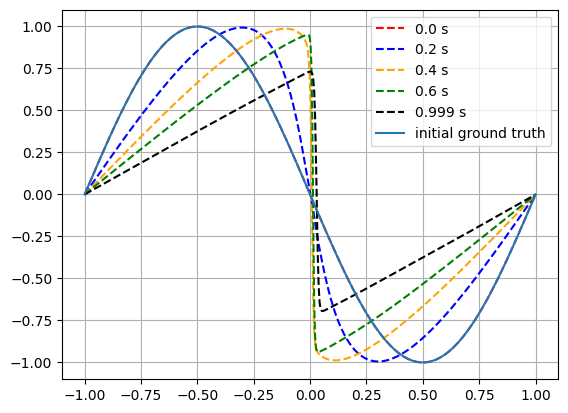

In [22]:
snapshots_ids = np.arange(0, T_DIM_F, T_DIM).astype('int')
snapshots_ids[-1] = T_DIM_F - 1

colors = ['red', 'blue', 'orange', 'green', 'black']

for i, s in enumerate(snapshots_ids):
    
    plt.plot(x_f, U_f[s, :], label=f'{s/T_DIM_F} s', c=colors[i], ls='--')

plt.plot(data_init, u_init, label='initial ground truth')
plt.grid(True)
plt.legend()
plt.show()